In [122]:
# Libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [123]:
# Importing data
Train = pd.read_csv('TrainScaled.csv').drop(columns='Unnamed: 0')
Test = pd.read_csv('TestScaled.csv').drop(columns='Unnamed: 0')
Train.head()

,gdp_per_capita ($),gdp_for_year ($),age,sex,generation,population-1,suicides_no-1,country,year,suicideRate
0,-0.630091,-0.170405,0.228086,0.962250,0.126435,0.189113,-0.111221,Argentina,2010,7.831615
1,-0.569353,-0.148444,0.228086,0.962250,0.200000,0.191271,-0.097785,Argentina,2011,7.659985
2,-0.555124,-0.140554,0.228086,0.856349,0.200000,0.194880,-0.098542,Argentina,2012,8.449141
3,-0.577180,-0.139636,0.247436,0.925820,0.247436,0.198003,-0.050675,Argentina,2013,7.686740
4,1.151472,0.153115,0.228086,0.962250,0.126435,-0.135590,-0.176921,Australia,2010,11.608080


In [124]:
# Dividing into X and Y
yTrain =  Train['suicideRate'].copy()
yTest =  Test['suicideRate'].copy()
XTrain = Train.drop(columns='suicideRate').copy()
XTest = Test.drop(columns='suicideRate').copy()
XTrain.head()

,gdp_per_capita ($),gdp_for_year ($),age,sex,generation,population-1,suicides_no-1,country,year
0,-0.630091,-0.170405,0.228086,0.962250,0.126435,0.189113,-0.111221,Argentina,2010
1,-0.569353,-0.148444,0.228086,0.962250,0.200000,0.191271,-0.097785,Argentina,2011
2,-0.555124,-0.140554,0.228086,0.856349,0.200000,0.194880,-0.098542,Argentina,2012
3,-0.577180,-0.139636,0.247436,0.925820,0.247436,0.198003,-0.050675,Argentina,2013
4,1.151472,0.153115,0.228086,0.962250,0.126435,-0.135590,-0.176921,Australia,2010


In [125]:
# Parameters
trainCountries = len(XTrain['country'].unique())
testCountries = len(XTest['country'].unique())
times = len(XTrain['year'].unique())
variables = len(XTrain.drop(columns=['year', 'country']).columns)
print(f"train countries:{trainCountries}, test countries:{testCountries}, times:{times}, variables:{variables}")

train countries:52, test countries:23, times:4, variables:7


In [126]:
# Reshaping X
idTrain = XTrain[['country', 'year']].copy()
idTest = XTest[['country', 'year']].copy()
XTrain = np.reshape(XTrain.drop(columns=['country', 'year']), (trainCountries, times, variables))
XTest = np.reshape(XTest.drop(columns=['country', 'year']), (testCountries, times, variables))
XTrain[0]

array([[-0.63009062, -0.17040468,  0.22808578,  0.96225045,  0.12643493,
         0.18911348, -0.11122131],
       [-0.56935292, -0.14844411,  0.22808578,  0.96225045,  0.2       ,
         0.19127059, -0.09778531],
       [-0.55512365, -0.14055392,  0.22808578,  0.85634884,  0.2       ,
         0.19488048, -0.0985424 ],
       [-0.57718048, -0.1396359 ,  0.24743583,  0.9258201 ,  0.24743583,
         0.19800329, -0.05067469]])

In the following chunk Im going to reshape the Y variable. This can be done in two ways:
- Selecting Y vector of size 52, it means I choose the 2013 suicide rate for each country. Shape 52
- Selecting all values, it means, each year will have a suicide rate. Shape (52,4)

The last approach is usefull for many2many architectures

In [127]:
# Rehsaping Y
yTrain = np.reshape(yTrain, (trainCountries, times))
yTest = np.reshape(yTest, (testCountries, times))
#yTrain = yTrain[:, 3]
#yTest = yTest[:, 3]
yTrain.shape

(52, 4)

Im creating 3 architectures for modeling: LSTM, GRU and a mix of them. Before modelling, a weights initializer will be set for all RNN.

In [128]:
initializer = keras.initializers.GlorotNormal(seed=1234)

In [129]:
# LSTM
LSTM = keras.models.Sequential()
LSTM.add(keras.layers.LSTM(units=100, input_shape=(times, variables), kernel_initializer=initializer,
                          return_sequences=True))
LSTM.add(keras.layers.LSTM(units=75, input_shape=(times, variables), kernel_initializer=initializer,
                          return_sequences=True))
LSTM.add(keras.layers.LSTM(units=50, input_shape=(times, variables), kernel_initializer=initializer,
                          return_sequences=True))
LSTM.add(keras.layers.LSTM(units=25, input_shape=(times, variables), kernel_initializer=initializer,
                          return_sequences=False))
LSTM.add(keras.layers.Dense(units=1, activation='linear'))
LSTM.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_31 (LSTM)              (None, 4, 100)            43200     
                                                                 
 lstm_32 (LSTM)              (None, 4, 75)             52800     
                                                                 
 lstm_33 (LSTM)              (None, 4, 50)             25200     
                                                                 
 lstm_34 (LSTM)              (None, 25)                7600      
                                                                 
 dense_19 (Dense)            (None, 1)                 26        
                                                                 
Total params: 128,826
Trainable params: 128,826
Non-trainable params: 0
_________________________________________________________________


When Return sequences is True, the LSTM layer return a matrix which each row represent a unique observation and each column is its fitter value for each time setted (4 in this case). When this parameter is false, the layer only returns a vector with the fitted value for the last time (t4 in this case) for each observaton.

In [130]:
# Training
LSTM.compile(loss='mean_squared_error', optimizer='adam')
historyLSTM = LSTM.fit(XTrain, yTrain, validation_data=(XTest, yTest), epochs=60, batch_size=32)

Epoch 1/60
2/2 [==============================] - 5s 1s/step - loss: 177.0001 - val_loss: 199.9768
Epoch 2/60
2/2 [==============================] - 0s 193ms/step - loss: 176.5247 - val_loss: 199.5290
Epoch 3/60
2/2 [==============================] - 0s 169ms/step - loss: 175.9338 - val_loss: 199.0039
Epoch 4/60
2/2 [==============================] - 0s 170ms/step - loss: 175.3423 - val_loss: 198.3695
Epoch 5/60
2/2 [==============================] - 0s 105ms/step - loss: 174.5129 - val_loss: 197.5775
Epoch 6/60
2/2 [==============================] - 0s 153ms/step - loss: 173.5706 - val_loss: 196.5880
Epoch 7/60
2/2 [==============================] - 0s 79ms/step - loss: 172.2673 - val_loss: 195.3170
Epoch 8/60
2/2 [==============================] - 0s 225ms/step - loss: 170.6687 - val_loss: 193.6851
Epoch 9/60
2/2 [==============================] - 0s 101ms/step - loss: 168.3588 - val_loss: 191.4964
Epoch 10/60
2/2 [==============================] - 0s 41ms/step - loss: 165.2985 - val

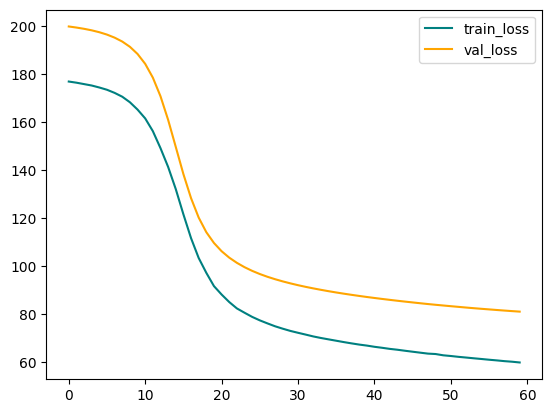

In [131]:
# Plotting loss
plt.plot(historyLSTM.history['loss'], color='teal', label='train_loss')
plt.plot(historyLSTM.history['val_loss'], color='orange', label='val_loss')
plt.legend(loc='best')
plt.show()

In [132]:
# GRU
GRU = keras.models.Sequential()
GRU.add(keras.layers.GRU(units=100, input_shape=(times, variables), kernel_initializer=initializer,
                          return_sequences=True))
GRU.add(keras.layers.GRU(units=100, input_shape=(times, variables), kernel_initializer=initializer,
                          return_sequences=False))
GRU.add(keras.layers.Dense(units=1, activation='linear'))
GRU.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_17 (GRU)                (None, 4, 100)            32700     
                                                                 
 gru_18 (GRU)                (None, 100)               60600     
                                                                 
 dense_20 (Dense)            (None, 1)                 101       
                                                                 
Total params: 93,401
Trainable params: 93,401
Non-trainable params: 0
_________________________________________________________________


In [133]:
# Training
GRU.compile(loss='mean_squared_error', optimizer='adam')
historyGRU = GRU.fit(XTrain, yTrain, validation_data=(XTest, yTest), epochs=50, batch_size=50)

Epoch 1/50
2/2 [==============================] - 2s 672ms/step - loss: 177.5715 - val_loss: 200.6016
Epoch 2/50
2/2 [==============================] - 0s 136ms/step - loss: 175.4434 - val_loss: 200.4033
Epoch 3/50
2/2 [==============================] - 0s 88ms/step - loss: 173.7727 - val_loss: 199.9113
Epoch 4/50
2/2 [==============================] - 0s 132ms/step - loss: 172.3171 - val_loss: 199.0335
Epoch 5/50
2/2 [==============================] - 0s 31ms/step - loss: 170.9140 - val_loss: 197.8406
Epoch 6/50
2/2 [==============================] - 0s 108ms/step - loss: 169.3859 - val_loss: 196.6890
Epoch 7/50
2/2 [==============================] - 0s 25ms/step - loss: 167.6734 - val_loss: 195.4220
Epoch 8/50
2/2 [==============================] - 0s 50ms/step - loss: 165.5925 - val_loss: 193.7241
Epoch 9/50
2/2 [==============================] - 0s 122ms/step - loss: 163.3082 - val_loss: 191.5695
Epoch 10/50
2/2 [==============================] - 0s 26ms/step - loss: 160.6611 - val

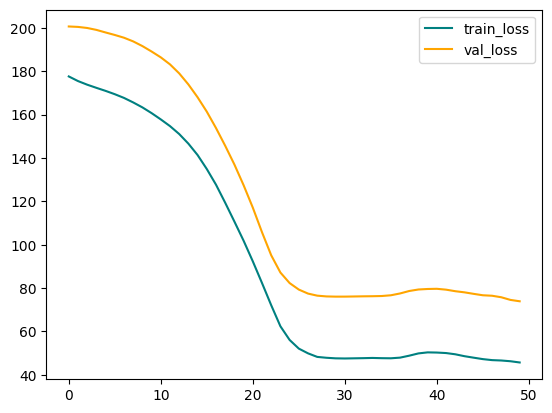

In [134]:
# Plotting loss
plt.plot(historyGRU.history['loss'], color='teal', label='train_loss')
plt.plot(historyGRU.history['val_loss'], color='orange', label='val_loss')
plt.legend(loc='best')
plt.show()

In [136]:
# Mix of layers
GRULSTM = keras.models.Sequential()
GRULSTM.add(keras.layers.GRU(units=50, kernel_initializer=initializer,
                             return_sequences=True))
GRULSTM.add(keras.layers.GRU(units=50, input_shape=(times, variables), kernel_initializer=initializer,
                              return_sequences=True))
GRULSTM.add(keras.layers.LSTM(units=50, input_shape=(times, variables), kernel_initializer=initializer,
                             return_sequences=True))
GRULSTM.add(keras.layers.LSTM(units=50, input_shape=(times, variables), kernel_initializer=initializer,
                              return_sequences=False))
GRULSTM.add(keras.layers.Dense(units=1, activation='linear'))
GRULSTM.build(input_shape=(None, times, variables))
GRULSTM.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_19 (GRU)                (None, 4, 50)             8850      
                                                                 
 gru_20 (GRU)                (None, 4, 50)             15300     
                                                                 
 lstm_35 (LSTM)              (None, 4, 50)             20200     
                                                                 
 lstm_36 (LSTM)              (None, 50)                20200     
                                                                 
 dense_21 (Dense)            (None, 1)                 51        
                                                                 
Total params: 64,601
Trainable params: 64,601
Non-trainable params: 0
_________________________________________________________________


In [137]:
# Training
GRULSTM.compile(loss='mean_squared_error', optimizer='adam')
historyGRULSTM = GRULSTM.fit(XTrain, yTrain, validation_data=(XTest, yTest), epochs=100, batch_size=50)

Epoch 1/100
2/2 [==============================] - 5s 1s/step - loss: 177.0565 - val_loss: 199.9317
Epoch 2/100
2/2 [==============================] - 0s 249ms/step - loss: 176.4173 - val_loss: 199.2856
Epoch 3/100
2/2 [==============================] - 0s 198ms/step - loss: 175.8181 - val_loss: 198.5701
Epoch 4/100
2/2 [==============================] - 0s 153ms/step - loss: 175.1701 - val_loss: 197.6931
Epoch 5/100
2/2 [==============================] - 0s 130ms/step - loss: 174.3822 - val_loss: 196.6888
Epoch 6/100
2/2 [==============================] - 0s 124ms/step - loss: 173.4328 - val_loss: 195.5261
Epoch 7/100
2/2 [==============================] - 0s 83ms/step - loss: 172.3012 - val_loss: 194.0044
Epoch 8/100
2/2 [==============================] - 0s 94ms/step - loss: 170.8387 - val_loss: 191.9616
Epoch 9/100
2/2 [==============================] - 0s 48ms/step - loss: 168.9874 - val_loss: 189.4385
Epoch 10/100
2/2 [==============================] - 0s 69ms/step - loss: 166.57

Epoch 82/100
2/2 [==============================] - 0s 32ms/step - loss: 50.3351 - val_loss: 75.2928
Epoch 83/100
2/2 [==============================] - 0s 33ms/step - loss: 50.4837 - val_loss: 75.2595
Epoch 84/100
2/2 [==============================] - 0s 33ms/step - loss: 50.5557 - val_loss: 75.2246
Epoch 85/100
2/2 [==============================] - 0s 32ms/step - loss: 50.5544 - val_loss: 75.1882
Epoch 86/100
2/2 [==============================] - 0s 34ms/step - loss: 50.5117 - val_loss: 75.1527
Epoch 87/100
2/2 [==============================] - 0s 33ms/step - loss: 50.4294 - val_loss: 75.1210
Epoch 88/100
2/2 [==============================] - 0s 33ms/step - loss: 50.3463 - val_loss: 75.0988
Epoch 89/100
2/2 [==============================] - 0s 32ms/step - loss: 50.2076 - val_loss: 75.0850
Epoch 90/100
2/2 [==============================] - 0s 33ms/step - loss: 50.0807 - val_loss: 75.0741
Epoch 91/100
2/2 [==============================] - 0s 34ms/step - loss: 49.9875 - val_loss

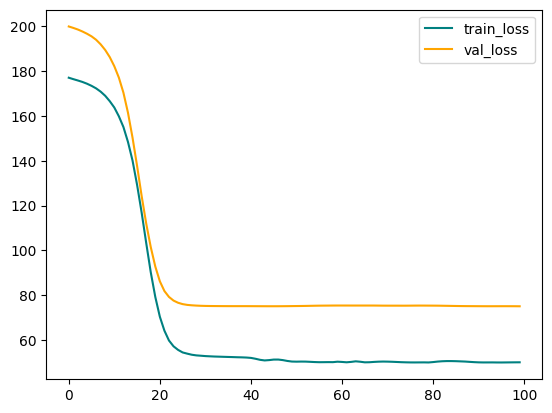

In [138]:
# Plotting loss
plt.plot(historyGRULSTM.history['loss'], color='teal', label='train_loss')
plt.plot(historyGRULSTM.history['val_loss'], color='orange', label='val_loss')
plt.legend(loc='best')
plt.show()

In [139]:
# Evaluating models
yhatLSTM = LSTM.predict(XTest)
yhatGRU = GRU.predict(XTest)
yhatMix = GRULSTM.predict(XTest)
yhatLSTM

1/1 [==============================] - 1s 828ms/step


array([[8.75133 ],
       [8.752737],
       [8.749726],
       [8.74985 ],
       [8.752433],
       [8.750171],
       [8.750643],
       [8.750915],
       [8.752377],
       [8.749814],
       [8.70895 ],
       [8.753114],
       [8.751729],
       [8.75185 ],
       [8.626746],
       [8.750338],
       [8.751143],
       [8.745532],
       [8.75249 ],
       [8.723253],
       [8.753906],
       [8.758239],
       [8.708769]], dtype=float32)

In [140]:
# Selecting last period
yTestLastPeriod = yTest[:, 3]
yTestLastPeriod

array([ 2.38377835, 18.00278525, 10.4181056 , 13.88903045,  5.53494642,
       15.87033224,  8.55539352,  3.74469303, 30.70772533,  5.14807069,
        7.46043738,  1.14714515, 20.02652076, 38.65850361,  5.14334413,
       11.67331719,  6.94191404, 12.66619114,  0.        ,  1.21802682,
       13.6301968 , 13.94291969,  8.02771853])

In [141]:
# Evaluating
print(mean_squared_error(yTestLastPeriod, yhatLSTM),
     mean_squared_error(yTestLastPeriod, yhatGRU),
     mean_squared_error(yTestLastPeriod, yhatMix))

88.72963460840249 82.30522051355129 83.31508810186321
